In [1]:
import pandas as pd
import numpy as np
from joblib import Parallel, delayed
import multiprocessing
import matplotlib.pyplot as plt
import heapq
from datetime import datetime, timedelta
import csv
import itertools

In [2]:
tasks_dataframe = pd.read_csv(r"C:\Users\Marina\OneDrive\Desktop\Cell_a.csv")

# 1. Dataset Analysis ( aggiungere IMA)

In [3]:
# Removing rows with CPU usage equal to 0 from the dataset
cpu_usage = tasks_dataframe['CPU'] > 0
tasks_dataframe = tasks_dataframe.drop(tasks_dataframe[~cpu_usage].index)
tasks_dataframe

,Job_ID,Task_ID,Arrival_Time,CPU,Memory
0,375000667413,0,603026300,0.041851,0.001169
1,375000669289,0,606413041,0.024968,0.001179
2,375000670586,0,608994453,0.024176,0.001173
3,375000670588,0,608994466,0.019552,0.001163
4,375000670590,0,609042903,0.028044,0.001179
...,...,...,...,...,...
2329127,400465207745,0,2678935469565,0.004677,0.000067
2329128,400465219425,0,2678943690687,0.000343,0.000004
2329129,400465219425,1,2678943690687,0.000557,0.000004
2329130,400465256347,0,2678955330224,0.002459,0.000050


In [4]:
# Converting the Arrival Time column from microseconds to seconds
tasks_dataframe['Arrival_Time'] = tasks_dataframe['Arrival_Time'] / 1000000

In [5]:
tasks_dataframe.head(10)

,Job_ID,Task_ID,Arrival_Time,CPU,Memory
0,375000667413,0,603.026300,0.041851,0.001169
1,375000669289,0,606.413041,0.024968,0.001179
2,375000670586,0,608.994453,0.024176,0.001173
3,375000670588,0,608.994466,0.019552,0.001163
4,375000670590,0,609.042903,0.028044,0.001179
5,375000670901,0,609.794657,0.027910,0.001144
6,375000670926,0,609.822664,0.030373,0.001137
7,375000670981,0,610.235344,0.018474,0.001024
8,375000671303,0,610.982397,0.025027,0.001188
9,375000671907,0,615.596769,8.744648,0.004997


In [6]:
#Calculating number of days needed to complete every tasks
min_time = tasks_dataframe['Arrival_Time'].min()
max_time = tasks_dataframe['Arrival_Time'].max()
diff_sec = max_time - min_time
diff_day = diff_sec / (24 * 60 * 60)
diff_day=round(diff_day,4)
print('Number of days needed to complete every tasks:', diff_day)

Number of days needed to complete every tasks: 30.9994


In [7]:
#Esamination of tasks in jobs
job_id_counts =  tasks_dataframe["Job_ID"].value_counts()
repeated_jobs = len(job_id_counts[job_id_counts > 1])

# print the number of Job_IDs that are repeated more than once
print(f"Number of Job_IDs that are repeated more than once: {repeated_jobs}")

Number of Job_IDs that are repeated more than once: 60173


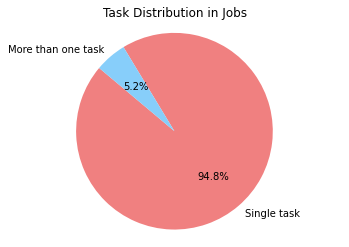

In [8]:
#Examination of tasks in jobs
job_id_counts = tasks_dataframe["Job_ID"].value_counts()
single_task = len(job_id_counts[job_id_counts<2])
more_tasks = len(job_id_counts[job_id_counts > 1])

sizes = [single_task, more_tasks]
labels = ['Single task', 'More than one task']
colors = ['lightcoral', 'lightskyblue']

# Create the pie chart
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)

# Add a title
plt.title("Task Distribution in Jobs")

# Display the chart
plt.axis('equal')
plt.show()

In [9]:
# variability of service time
service_time = tasks_dataframe['CPU']/0.1
var = service_time.var()
media = service_time.mean()
std = service_time.std()
print('Variance and Mean of the service time',var, media, std)

Variance and Mean of the service time 1879441.3390325576 40.428826789453844 1370.9271822502308


In [10]:
#variability of memory usage
memory_us_var = tasks_dataframe['Memory'].var()
memory_us_mean = tasks_dataframe['Memory'].mean()
print('variance and mean of the memory usage',memory_us_var, memory_us_mean)

variance and mean of the memory usage 2.6257930966316857e-05 0.0015251060542106022


Number of jobs with service time < 1: 859454
Number of jobs with service time > 1: 293985
max service time per job 11847671.94


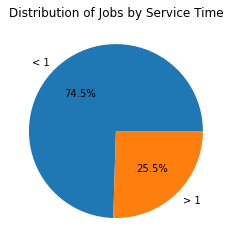

In [11]:
## alculate the service time taken for all tasks in the same job 
tasks_dataframe['Service_Time'] = tasks_dataframe['CPU'] / 0.1
service_time_per_job = tasks_dataframe.groupby('Job_ID')['Service_Time'].sum()
max_service_time_per_job=service_time_per_job.max()
max_service_time_per_job=round(max_service_time_per_job,2)
jobs_less_1 = service_time_per_job[service_time_per_job <1]
jobs_over_1 = service_time_per_job[service_time_per_job >1]
# Count the number of jobs with service time > 1
num_jobs_less_1 = len(jobs_less_1)
num_jobs_over_1 = len(jobs_over_1)
print(f"Number of jobs with service time < 1: {num_jobs_less_1}")
print(f"Number of jobs with service time > 1: {num_jobs_over_1}")
print('max service time per job',max_service_time_per_job)

labels = ['< 1',  '> 1']
sizes = [num_jobs_less_1, num_jobs_over_1]

# Create the pie chart
plt.pie(sizes, labels=labels, autopct='%1.1f%%')
plt.title('Distribution of Jobs by Service Time')
plt.show()

# 2. Algorithms

## 2.1 Dispatching Algorithm

### 2.1.1 LWL (Least Work Left) 

- Assigns the processing resource to the process or job with the least amount of remaining work, reducing the waiting time for processing and thus the mean job response time.

- In LWL scheduling, the system keeps track of the remaining work or workload of each process or job. When a resource becomes available, LWL selects the process or job with the smallest amount of unfinished work and allocates the resource to it. This approach aims to minimize the time required to complete each job and reduce overall response times.

- By prioritizing the processes or jobs with less work left, LWL can effectively distribute resources and ensure that jobs are processed more efficiently. This helps to decrease the waiting time for each job, leading to a reduction in the mean job response time.

### 2.2.2 RR (Round Robin)

- Fair treatment of jobs: RR is a policy that provides fair treatment to all jobs by assigning them a sequential execution round. This means that each job will receive a portion of execution time, regardless of the number of tasks it contains. This way, jobs with only one task will not be penalized compared to jobs with a larger number of tasks.

- Simplicity and low overhead: RR is a relatively simple dispatching policy to implement and manage. It does not require monitoring the remaining work levels of jobs like LWL, which could introduce some level of complexity and overhead in the system.

- Reduced response time for single-task jobs: Given that you have many jobs with only one task, using RR may lead to faster response time for these jobs. Since each job receives a sequential execution round, single-task jobs will be served quickly without having to wait for the completion of other tasks within the same job

- An index (rr_server_index) is initialized to keep track of the current server for task assignment.
- During the iteration of the task queue (task_queue), the next task is assigned to the server identified by the index rr_server_index % num_servers. - The % operator calculates the remainder of the division between rr_server_index and num_servers, ensuring that the index stays within the valid range of available servers.
- After the task is assigned, the rr_server_index is incremented so that the next task is assigned to the next server in the sequence.
- The workload (task) is then added to the queue of the corresponding server (servers[server_id].append(task)).

## 2.2 Scheduling Algorithms

Among the two scheduling policies, FCFS (First-Come, First-Served) and SJN (Shortest Job Next), the SJN policy generally tends to minimize the mean job response time compared to FCFS.

### 2.2.1 FCFS

- The FCFS algorithm processes requests based on their arrival order, assigning servers to them sequentially.
- Requests are served one after another, without considering their duration or job complexity.
- If a long-duration request is processed before a shorter one, the overall response time for requests can increase because the shorter requests have to wait longer.

### 2.2.2 SJN

- The SJN algorithm prioritizes requests based on their expected or estimated duration.
- When a new request arrives, the SJN algorithm selects the request with the shortest duration and processes it first.
- This approach reduces the overall response time as shorter requests are served quickly, thus reducing the wait time for other requests.

In general, the SJN policy is considered more efficient than FCFS in minimizing the mean job response time since it prioritizes shorter requests that require less processing time. This helps reduce the overall waiting time and improve the average response time for requests.

## 3. Unfinished Work

$$ U_{n} = max{(0, U_{n−1} − T_{n})} + X_{n}, n ≥ 1 $$
where:
- U_0 = 0;
- T_n is the inter-arrival time between arrival n − 1 and n;
- X_n is the service time or the n-th arriving task.

In [171]:
class Task:
    def __init__(self, job_id, task_id, arrival_time, cpu_usage, memory_usage):
        self.job_id = job_id
        self.task_id = task_id
        self.arrival_time = arrival_time
        self.cpu_usage = cpu_usage
        self.memory_usage = memory_usage
        self.completion_time = None
        self.service_time = cpu_usage / 0.1

    def __lt__(self, other):
        return self.service_time < other.service_time

# Function to simulate baseline (LWL dispatching and FCFS scheduling)
def calculate_completion_time_baseline(tasks, num_servers):
    # List of servers, each server can have multiple tasks
    servers = [[] for _ in range(num_servers)]  
    # Utilization for each server
    utilization = {}
    # Unfinished work for each server
    unfinished_work = [0] *  num_servers 
    # Dictionary to store completion time for each task
    task_completion_times = {}  
    service_times = {}
    message_loads = 0
    
    for n in range(len(tasks)):
        # LWL Dispatching
        available_servers = [i for i, server_tasks in enumerate(servers) if not server_tasks]  
        if available_servers:
            # Choose the first available server
            server_id = available_servers[0]  
        else:
            # Find the server with the least unfinished work
            server_id = unfinished_work.index(min(unfinished_work))  
        
        # Assign the task to the server
        servers[server_id].append(tasks[n])

        # Increase the message load for each task assignment
        message_loads += num_servers + 1

        # Save Utilization for each server      
        if server_id in utilization:
            utilization[server_id].append(tasks[n].service_time)
        else:
            utilization[server_id] = [tasks[n].service_time]

        # FCFS Scheduling
        # Calculate completion time for each task
        if n > 0:
            inter_arrival_time = tasks[n].arrival_time - tasks[n-1].arrival_time
        else:
            inter_arrival_time = 0
            
        unfinished_work[server_id] = max(0, unfinished_work[server_id] - inter_arrival_time) + tasks[n].service_time

        for i, server_tasks in enumerate(servers):
            if i != server_id:
                unfinished_work[i] -= inter_arrival_time

        # Save service time and task completion time
        if tasks[n].job_id in service_times:
            service_times[tasks[n].job_id] += tasks[n].service_time
        else:
            service_times[tasks[n].job_id] = tasks[n].service_time
            
        task_completion_times[(tasks[n].job_id, tasks[n].task_id, tasks[n].arrival_time, tasks[n].cpu_usage)] = unfinished_work[server_id]

    # Compute average message load    
    mean_message_load = message_loads / len(tasks)  
    return task_completion_times, service_times, utilization, mean_message_load

#######

# Function to simulate RR dispatching and SJN scheduling
def calculate_completion_time_our_algorithm(tasks, num_servers):
    servers = [[] for _ in range(num_servers)]
    unfinished_work = [0] * num_servers
    task_completion_times = {}
    service_times = {}
    message_loads = 0
    utilization = {}

    # Use a priority queue to order tasks by shortest job next (SJN scheduling)
    task_queue = []
    for n in range(len(tasks)):
        heapq.heappush(task_queue, (tasks[n].arrival_time, tasks[n].service_time, tasks[n]))

    while task_queue:
        # Get the next task with the shortest remaining service time
        _, _, task = heapq.heappop(task_queue)
        
        # LWL Dispatching
        available_servers = [i for i, server_tasks in enumerate(servers) if not server_tasks]  
        if available_servers:
            # Choose the first available server
            server_id = available_servers[0]  
        else:
            # Find the server with the least unfinished work
            server_id = unfinished_work.index(min(unfinished_work)) 
        
        # Assign the task to the server
        servers[server_id].append(task)
        
        # Increase the message load for each task assignment
        message_loads += num_servers + 1

        # Compute Utilization
        if server_id in utilization:
            utilization[server_id].append(task.service_time)
        else:
            utilization[server_id] = [task.service_time]

        # Calculate completion time for the task
        if len(servers[server_id]) > 1:
            inter_arrival_time = task.arrival_time - servers[server_id][-2].arrival_time
        else:
            inter_arrival_time = 0
            
        unfinished_work[server_id] = max(0, unfinished_work[server_id] - inter_arrival_time) + task.service_time

        for i, server_tasks in enumerate(servers):
            if i != server_id:
                unfinished_work[i] -= inter_arrival_time
                
        # Save service time and task completion time
        if task.job_id in service_times:
            service_times[task.job_id] += task.service_time
        else:
            service_times[task.job_id] = task.service_time
        
        task_completion_times[(task.job_id, task.task_id, task.arrival_time, task.cpu_usage)] = unfinished_work[server_id]
        
    # Compute average message load
    mean_message_load = message_loads / len(tasks)  

    return task_completion_times, service_times, utilization, mean_message_load


In [169]:
# Read the dataset and create Task objects
tasks = []
for index, row in tasks_dataframe.iterrows():
    job_id = int(row[0])
    task_id = int(row[1])
    arrival_time = float(row[2])
    cpu_usage = float(row[3])
    memory_usage = float(row[4])
    
    task = Task(job_id, task_id, arrival_time, cpu_usage, memory_usage)
    tasks.append(task)
        
# Number of Servers
N = 64

# Simulate baseline (LWL dispatching and FCFS scheduling)
completion_times_baseline, service_times_baseline, utilization_baseline, mean_message_load_baseline = calculate_completion_time_baseline(tasks, N)

In [172]:
# Simulate our algorithm (LWL dispatching and SJN scheduling)
completion_times_our_algorithm, service_times_our_algorithm, utilization_our_algorithm, mean_message_load_our_algorithm = calculate_completion_time_our_algorithm(tasks, N)

# 3. Metrics

## 3.1 Job response time R

Time elapsing since the arrival of the first arriving task of a job until all tasks belonging to that job
have been fully served. The mean job response time R is obtained by averaging response times of all jobs

In [173]:
# Job Mean Response Time R of the baseline
job_response_times_baseline = {}
for (job_id, task_id, arrival_time, cpu_usage), completion_time in completion_times_baseline.items():
    if job_id not in job_response_times_baseline:
        job_response_times_baseline[job_id] = [completion_time]
    else:
        job_response_times_baseline[job_id].append(completion_time)
        
max_times_baseline = {}
for job_id in job_response_times_baseline:
    max_times_baseline[job_id] =  max(job_response_times_baseline[job_id])
    
job_mean_response_time_baseline = np.mean(list(max_times_baseline.values()))
print("Job Mean Response Time R of the baseline:" , job_mean_response_time_baseline)

# Job Mean Response Time R of our algorithm
job_response_times_our_algorithm = {}
for (job_id, task_id, arrival_time, cpu_usage), completion_time in completion_times_our_algorithm.items():
    if job_id not in job_response_times_our_algorithm:
        job_response_times_our_algorithm[job_id] = [completion_time]
    else:
        job_response_times_our_algorithm[job_id].append(completion_time)
        
max_times_our_algorithm = {}
for job_id in job_response_times_our_algorithm:
    max_times_our_algorithm[job_id] = max(job_response_times_our_algorithm[job_id])

job_mean_response_time_our_algorithm = np.mean(list(max_times_our_algorithm.values()))
print("Job Mean Response Time R of our algorithm:", job_mean_response_time_our_algorithm)

Job Mean Response Time R of the baseline: 27603.90113509617
Job Mean Response Time R of our algorithm: 1050.7499664989934


In [174]:
print("Job Mean Response Time R of the baseline:" , timedelta(seconds = job_mean_response_time_baseline))
print("Job Mean Response Time R of our algorithm:", timedelta(seconds = job_mean_response_time_our_algorithm))

Job Mean Response Time R of the baseline: 7:40:03.901135
Job Mean Response Time R of our algorithm: 0:17:30.749966


## 3.2 Job slowdown S

Ratio of response time of the job to the sum of service times of all tasks belonging to the job. The mean job slowdown S is obtained by averaging slowdown values of all jobs.

In [175]:
# Job slowdown S of the baseline
job_slowdown_jobs_baseline = []
for job_id, max_time in max_times_baseline.items():
    service_time = service_times_baseline.get(job_id)
    job_slowdown_jobs_baseline.append(max_time/service_time)

job_slowdown_S_baseline = np.mean(job_slowdown_jobs_baseline)
print("Job Slowdown S of baseline: ", job_slowdown_S_baseline)

# Job slowdown S of our algorithm
job_slowdown_jobs_our_algorithm = []
for job_id, max_time in max_times_our_algorithm.items():
    service_time = service_times_our_algorithm.get(job_id)
    job_slowdown_jobs_our_algorithm.append(max_time/service_time)

job_slowdown_S_our_algorithm= np.mean(job_slowdown_jobs_our_algorithm)
print("Job Slowdown S of our algorithm: ", job_slowdown_S_our_algorithm)

Job Slowdown S of baseline:  1241675.5748628979
Job Slowdown S of our algorithm:  17029.013495864863


In [176]:
print("Job Slowdown S of baseline: ", timedelta(seconds = job_slowdown_S_baseline))
print("Job Slowdown S of our algorithm: ", timedelta(seconds = job_slowdown_S_our_algorithm))

Job Slowdown S of baseline:  14 days, 8:54:35.574863
Job Slowdown S of our algorithm:  4:43:49.013496


## 3.3 Utilization coefficient of server  k, ρk 

Fraction of time that the server k is busy serving tasks. The overall mean utilization coefficient is ρ = (ρ1 + · · · + ρN)/N.

In [177]:
# Utilization coefficient of baseline
for server in utilization_baseline:
    utilization_baseline[server] = np.mean(utilization_baseline[server]) 

mean_utilization_baseline = sum(utilization_baseline.values()) / len(utilization_baseline.keys())
print("Mean Utilization of the baseline:", mean_utilization_baseline)

# Utilization coefficient of our algorithm

for server in utilization_our_algorithm.keys():
    utilization_our_algorithm[server] = np.mean(utilization_our_algorithm[server])

mean_utilization_our_algorithm= sum(utilization_our_algorithm.values()) / len(utilization_our_algorithm.keys())
print("Mean Utilization of our algorithm:", mean_utilization_our_algorithm)

Mean Utilization of the baseline: 41.28044984576744
Mean Utilization of our algorithm: 40.429413226275884


In [178]:
print("Mean Utilization of the baseline:", timedelta(seconds = mean_utilization_baseline))
print("Mean Utilization of our algorithm:", timedelta(seconds = mean_utilization_our_algorithm))

Mean Utilization of the baseline: 0:00:41.280450
Mean Utilization of our algorithm: 0:00:40.429413


## 3.4 Messaging load L

Number of messages exchanged between the dispatcher and servers for a given task dispatching. The mean message load L is obtained by averaging message load values of all tasks.

In [179]:
print("Mean Message Load of the baselien:", mean_message_load_baseline)
print("Mean Message Load of our algorithm:", mean_message_load_our_algorithm)

Mean Message Load of the baselien: 65.0
Mean Message Load of our algorithm: 65.0


# 4 Performance Evaluation

## 4.1 Complementary Cumulative Distribution Function (eCCDF) 

In [180]:
def indicator(X,t):
    if X<=t:
        return(1)
    else:
        return(0)        

def eCCDF(X, t):
    n=len(X)
    return(1-1/(n-1)*np.sum([indicator(i,t) for i in X]))

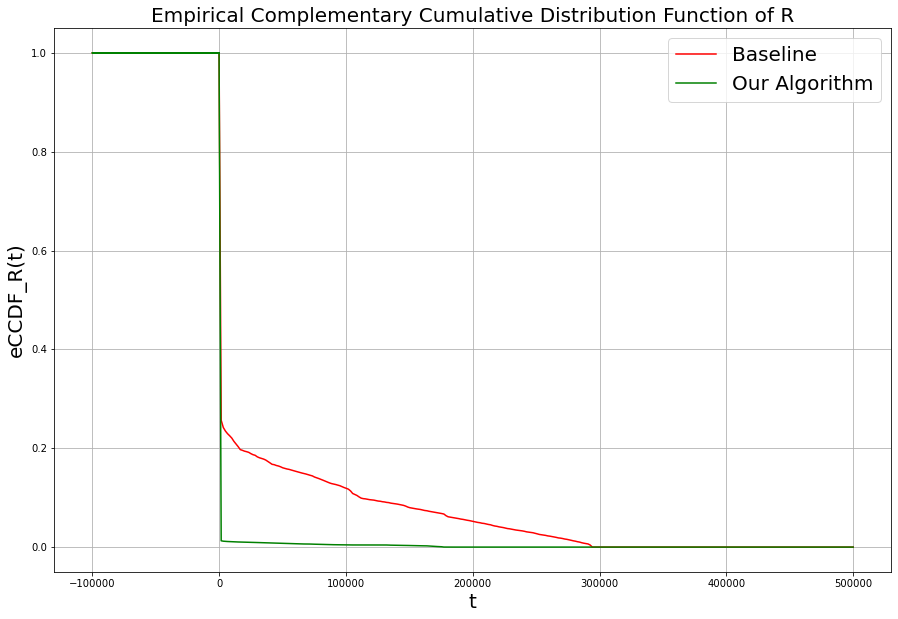

In [186]:
num_cores=multiprocessing.cpu_count() 

times_plot = [-10**i for i in range(1,6)]+list(np.linspace(0, 10**6/2, 300))
emp_response_our_algorithm = Parallel(n_jobs=num_cores)(delayed(eCCDF)( list(max_times_our_algorithm.values()) , i ) for i in times_plot)
emp_response_baseline = Parallel(n_jobs=num_cores)(delayed(eCCDF)( list(max_times_baseline.values()) , i ) for i in times_plot)

plt.figure(figsize=(15, 10))
plt.plot(times_plot, emp_response_baseline, 'r', label='Baseline')
plt.plot(times_plot, emp_response_our_algorithm, 'g', label='Our Algorithm')
plt.grid()
plt.xlabel('t', fontsize = 20)
plt.ylabel('eCCDF_R(t)', fontsize = 20)
plt.title('Empirical Complementary Cumulative Distribution Function of R', fontsize = 20)
plt.legend(fontsize = 20)
plt.show()

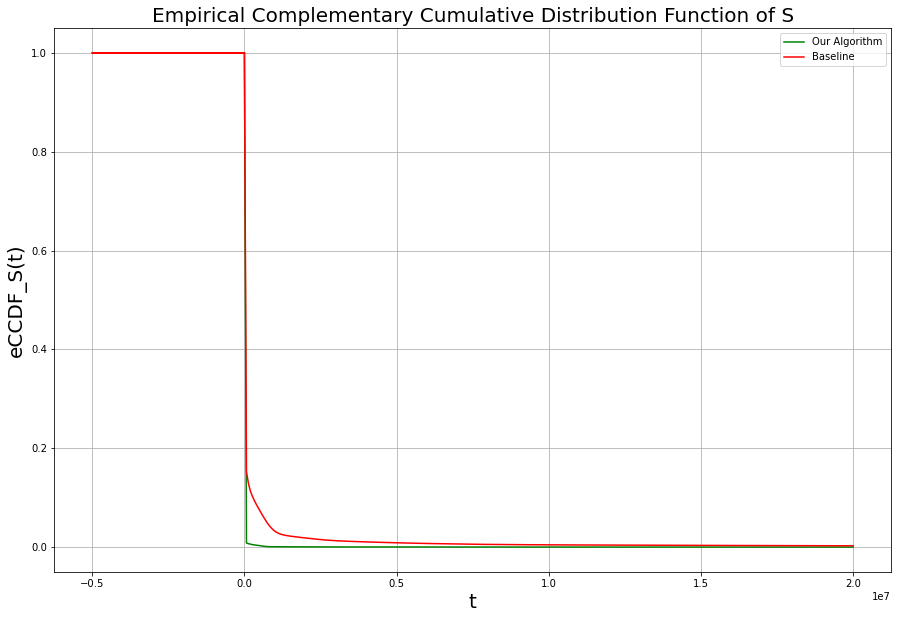

In [187]:
times_plot = [-10**i/2 for i in range(3,8)]+list(np.linspace(0, 10**7*2, 300))

emp_slowdown_our_algorithm = Parallel(n_jobs=num_cores)(delayed(eCCDF)(job_slowdown_jobs_our_algorithm , i ) for i in times_plot)
emp_slowdown_baseline = Parallel(n_jobs=num_cores)(delayed(eCCDF)( job_slowdown_jobs_baseline , i ) for i in times_plot)

plt.figure(figsize=(15, 10))
plt.plot(times_plot, emp_slowdown_our_algorithm,'g', label='Our Algorithm')
plt.plot(times_plot, emp_slowdown_baseline,'r', label='Baseline')
plt.grid()
plt.xlabel('t', fontsize = 20)
plt.ylabel('eCCDF_S(t)', fontsize = 20)
plt.title('Empirical Complementary Cumulative Distribution Function of S', fontsize = 20)
plt.legend()
plt.show()

## 4.2 Table with values of ρk, k = 1, . . . , 64

In [183]:
ρ_k = pd.DataFrame.from_dict({'Server Number': list(range(64)), 'ρ Baseline': utilization_baseline.values(),'ρ Our_Algorithm': utilization_our_algorithm.values()})
ρ_k

,Server Number,ρ Baseline,ρ Our_Algorithm
0,0,48.846715,53.987530
1,1,29.139624,39.460331
2,2,38.154556,34.404888
3,3,40.223923,37.736139
4,4,39.804670,40.246681
...,...,...,...
59,59,34.370633,33.285259
60,60,38.569273,40.010211
61,61,37.990378,54.536095
62,62,48.139232,42.389247


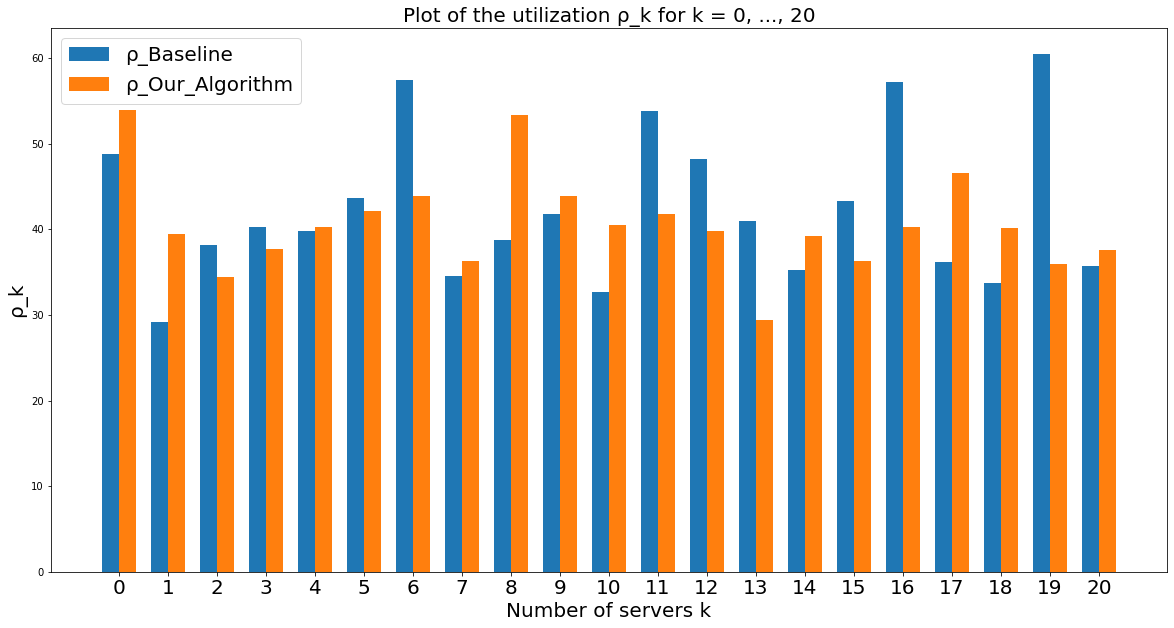

In [184]:
ρ_Baseline = ρ_k['ρ Baseline'].loc[0:20]
ρ_Our_Algorithm = ρ_k['ρ Our_Algorithm'].loc[0:20]

index = np.arange(len(ρ_Baseline))
bar_width = 0.35

fig, ax = plt.subplots(figsize=(20, 10))
baseline = ax.bar(index, ρ_Baseline , bar_width,
                label='ρ_Baseline')

our_algorithm = ax.bar(index+bar_width, ρ_Our_Algorithm ,
                 bar_width, label='ρ_Our_Algorithm')

ax.set_xlabel('Number of servers k', fontsize = 20)
ax.set_ylabel('ρ_k', fontsize = 20)
ax.set_title('Plot of the utilization ρ_k for k = 0, ..., 20', fontsize = 20)
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(ρ_k['Server Number'].loc[0:20], fontsize = 20)
ax.legend(fontsize = 20)
plt.show()

## 4.3 Comparison between Baseline and Our Algorithm

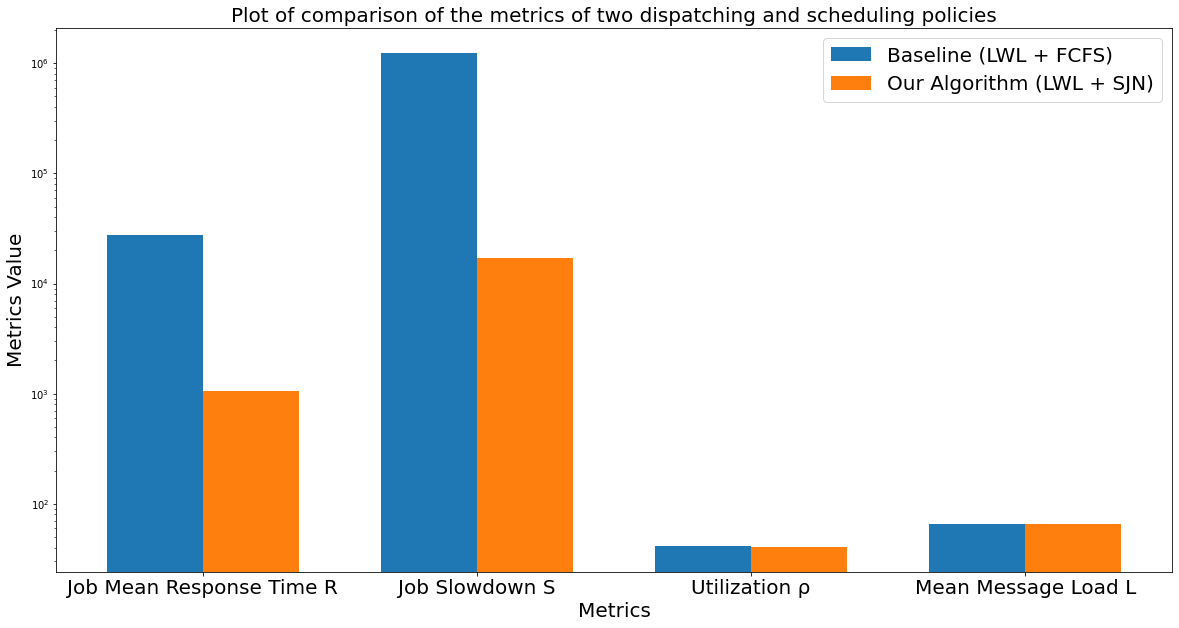

In [189]:
baseline = [job_mean_response_time_baseline, job_slowdown_S_baseline, mean_utilization_baseline, mean_message_load_baseline]
our_algorithm = [job_mean_response_time_our_algorithm, job_slowdown_S_our_algorithm, mean_utilization_our_algorithm, mean_message_load_our_algorithm]

index = np.arange(4)
bar_width = 0.35

fig, ax = plt.subplots(figsize=(20, 10))
baseline = ax.bar(index, baseline, bar_width,
                label="Baseline (LWL + FCFS)")

our_algorithm = ax.bar(index+bar_width, our_algorithm,
                 bar_width, label="Our Algorithm (LWL + SJN)")

ax.set_xlabel('Metrics', fontsize = 20)
ax.set_ylabel('Metrics Value', fontsize = 20)
ax.set_title('Plot of comparison of the metrics of two dispatching and scheduling policies', fontsize = 20)
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(['Job Mean Response Time R', 'Job Slowdown S', 'Utilization ρ', 'Mean Message Load L'], fontsize = 20)
ax.legend(fontsize = 20)
plt.yscale('log')
plt.show()

# 4. Example

In [8]:
######ESEMPIO######
tasks_2 = [Task(0, 0, 0, 1.5, 0.3),
         Task(0, 1, 0, 2.2, 0.5),
         Task(0, 2, 0, 2.5, 0.5), 
         Task(1, 1, 3, 0.8, 0.7),
         Task(2, 0, 4, 3.0, 0.9)]
            
    
µ = 0.1
N = 2
completion_times, service_times, utilization, mean_message_load = calculate_completion_time_baseline(tasks_2, N)

# Print completion time for each task
for (job_id, task_id, arrival_time, cpu_usage), completion_time in completion_times.items():
    print(f"Job ID: {job_id}, Task ID: {task_id}, Arrival Time : {arrival_time}, CPU : {cpu_usage},  Completion Time: {completion_time}")

Job ID: 0, Task ID: 0, Arrival Time : 0, CPU : 1.5,  Completion Time: 15.0
Job ID: 0, Task ID: 1, Arrival Time : 0, CPU : 2.2,  Completion Time: 22.0
Job ID: 0, Task ID: 2, Arrival Time : 0, CPU : 2.5,  Completion Time: 40.0
Job ID: 1, Task ID: 1, Arrival Time : 3, CPU : 0.8,  Completion Time: 27.0
Job ID: 2, Task ID: 0, Arrival Time : 4, CPU : 3.0,  Completion Time: 56.0


In [9]:
ompletion_times, service_times, utilization, mean_message_load = calculate_completion_time_our_algorithm(tasks_2, N)

# Print completion time for each task
for (job_id, task_id, arrival_time, cpu_usage), completion_time in completion_times.items():
    print(f"Job ID: {job_id}, Task ID: {task_id}, Arrival Time : {arrival_time}, CPU : {cpu_usage},  Completion Time: {completion_time}")

0
1
0
1
0
Job ID: 0, Task ID: 0, Arrival Time : 0, CPU : 1.5,  Completion Time: 15.0
Job ID: 0, Task ID: 1, Arrival Time : 0, CPU : 2.2,  Completion Time: 22.0
Job ID: 0, Task ID: 2, Arrival Time : 0, CPU : 2.5,  Completion Time: 40.0
Job ID: 1, Task ID: 1, Arrival Time : 3, CPU : 0.8,  Completion Time: 27.0
Job ID: 2, Task ID: 0, Arrival Time : 4, CPU : 3.0,  Completion Time: 56.0
